# Function Generation for the Training of λ-Nets

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes


config = {
    'function_family': {
        'maximum_depth': 4,
        'beta': 1,
        'decision_sparsity': 1,
        'fully_grown': True,
        'dt_type': 'vanilla', #'vanilla', 'SDT'
    },
    'data': {
        'number_of_variables': 10, 
        'num_classes': 2,
        
        'function_generation_type': 'make_classification_trained', # 'make_classification', 'make_classification_trained', 'random_decision_tree', 'random_decision_tree_trained'
        'objective': 'classification', # 'regression'
        
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform',       
                
        'lambda_dataset_size': 5000, #number of samples per function
        'number_of_generated_datasets': 100,
    }, 
    'computation':{
        'n_jobs': 10,
        'use_gpu': False,
        'gpu_numbers': '0',
        'RANDOM_SEED': 0,   
    }
}


In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['computation'])

## Imports

In [3]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

from itertools import product       # forms cartesian products
from more_itertools import random_product 
from tqdm import tqdm_notebook as tqdm
import pickle

import numpy as np

import pandas as pd
from joblib import Parallel, delayed

import random 
from random import sample 

import os
import sys

from sklearn.datasets import make_regression
from sklearn.preprocessing import MinMaxScaler

from sympy import Symbol, sympify

        
import seaborn as sns
        
import random 

import warnings

from time import perf_counter



from sklearn.datasets import load_iris, load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from utilities.DecisionTree_BASIC import SDT
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree
from matplotlib import pyplot as plt
from IPython.display import Image

import numpy as np
import torch
np.set_printoptions(suppress=True)
torch.set_printoptions(sci_mode=False)

In [4]:
#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################
sns.set_style("darkgrid")

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 500)

warnings.filterwarnings('ignore')

In [5]:
from utilities.utility_functions import *
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################

#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['computation'])

#initialize_utility_functions_config_from_curent_notebook(config)

#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(config, path_type='data_creation'))
generate_directory_structure()

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

In [6]:
print(path_identifier_function_data)

lNetSize5000_numDatasets100_var10_class2_make_classification_trained_xMax1_xMin0_xDistuniform_depth4_beta1_decisionSpars1_vanilla_fullyGrown


# Function Generation

In [7]:
if function_generation_type == 'random_decision_tree':
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky')
    result_list = parallel(delayed(generate_data_random_decision_tree)(config, seed=RANDOM_SEED+i) for i in range(number_of_generated_datasets))
elif function_generation_type == 'random_decision_tree_trained':
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='sequential')
    result_list = parallel(delayed(generate_data_random_decision_tree_trained)(config, seed=RANDOM_SEED+i) for i in range(number_of_generated_datasets))  
elif function_generation_type == 'make_classification':
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky')
    result_list = parallel(delayed(generate_data_make_classification)(config, seed=RANDOM_SEED+i) for i in range(number_of_generated_datasets)) 
elif function_generation_type == 'make_classification_trained':
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky')
    result_list = parallel(delayed(generate_data_make_classification_decision_tree_trained)(config, seed=RANDOM_SEED+i) for i in range(number_of_generated_datasets))    

function_identifier_list = generate_decision_tree_identifier(config)  
identifier_series_list = [pd.Series(result[0],  index=function_identifier_list) for result in result_list]

function_df = pd.DataFrame(data=np.array([result[0] for result in result_list]), columns=function_identifier_list)

X_data_list = [[identifier_series, pd.DataFrame(result[1], columns=['x' + str(i) for i in range(number_of_variables)])] for identifier_series, result in zip(identifier_series_list, result_list)]
y_data_list = [[identifier_series, pd.DataFrame(result[2], columns=['result'])] for identifier_series, result in zip(identifier_series_list, result_list)]
y_data_raw_list = [[identifier_series, pd.DataFrame(result[3], columns=['result_raw'])] for identifier_series, result in zip(identifier_series_list, result_list)]


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    8.7s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    9.0s finished


In [8]:
function_df.head()

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,feat11,feat12,feat13,feat14,split0,split1,split2,split3,split4,split5,split6,split7,split8,split9,split10,split11,split12,split13,split14,lp0,lp1,lp2,lp3,lp4,lp5,lp6,lp7,lp8,lp9,lp10,lp11,lp12,lp13,lp14,lp15
0,0.404,0.471,0.647,0.257,0.351,0.338,0.511,0.448,0.445,0.682,0.516,0.649,0.604,0.317,0.055,5.000,0.000,4.000,2.000,7.000,3.000,5.000,1.000,0.000,4.000,4.000,7.000,4.000,7.000,8.000,1.000,0.000,0.979,0.758,1.000,0.000,0.260,0.006,0.000,1.000,0.994,0.859,0.750,0.023,0.000,0.961
1,0.522,0.647,0.357,0.618,0.325,0.592,0.554,0.614,0.480,0.645,0.732,0.490,0.725,0.515,0.420,8.000,9.000,7.000,0.000,4.000,8.000,8.000,9.000,9.000,7.000,9.000,2.000,9.000,0.000,7.000,0.986,0.741,0.971,0.213,0.861,0.000,0.349,0.000,0.136,0.937,0.155,0.774,0.377,0.067,0.109,0.012
2,0.561,0.364,0.427,0.537,0.553,0.701,0.629,0.474,0.368,0.519,0.624,0.514,0.700,0.523,0.525,6.000,9.000,3.000,7.000,8.000,2.000,7.000,4.000,5.000,1.000,3.000,9.000,8.000,8.000,8.000,0.113,0.396,0.172,0.772,0.446,0.671,0.819,0.385,0.518,0.870,0.014,0.571,0.114,0.295,0.490,0.888
3,0.598,0.364,0.672,-1.000,0.829,0.541,0.557,-1.000,-1.000,0.662,0.512,0.540,0.303,0.582,0.808,5.000,1.000,7.000,-1.000,1.000,0.000,9.000,-1.000,-1.000,8.000,5.000,2.000,3.000,4.000,5.000,1.000,1.000,1.000,1.000,0.008,0.667,0.000,0.853,0.756,0.980,0.929,0.070,0.124,0.868,1.000,0.250
4,0.389,0.561,0.411,0.487,0.635,0.394,0.186,0.224,0.534,0.473,0.156,-1.000,0.348,0.464,0.420,2.000,5.000,4.000,8.000,7.000,4.000,6.000,0.000,5.000,8.000,3.000,-1.000,6.000,0.000,4.000,0.500,0.000,1.000,0.714,0.053,0.398,0.944,0.060,0.000,0.000,0.250,1.000,0.000,1.000,0.667,0.999


In [9]:
X_data_list[0][0].head(10)

feat0   0.404
feat1   0.471
feat2   0.647
feat3   0.257
feat4   0.351
feat5   0.338
feat6   0.511
feat7   0.448
feat8   0.445
feat9   0.682
dtype: float64

In [10]:
X_data_list[0][1].head(10)

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9
0,0.710,0.516,0.592,0.592,0.710,0.366,0.516,0.499,0.278,0.278
1,0.289,0.309,0.442,0.442,0.289,0.344,0.309,0.471,0.686,0.686
2,0.534,0.726,0.533,0.533,0.534,0.688,0.726,0.552,0.494,0.494
3,0.549,0.559,0.491,0.491,0.549,0.517,0.559,0.646,0.281,0.281
4,0.619,0.567,0.400,0.400,0.619,0.223,0.567,0.571,0.461,0.461
5,0.622,0.312,0.762,0.762,0.622,0.213,0.312,0.443,0.642,0.642
6,0.513,0.435,0.485,0.485,0.513,0.361,0.435,0.454,0.210,0.210
7,0.522,0.385,0.499,0.499,0.522,0.110,0.385,0.671,0.732,0.732
8,0.663,0.492,0.578,0.578,0.663,0.178,0.492,0.563,0.514,0.514
9,0.594,0.575,0.472,0.472,0.594,0.637,0.575,0.740,0.319,0.319


In [11]:
y_data_list[0][0].head(10)

feat0   0.404
feat1   0.471
feat2   0.647
feat3   0.257
feat4   0.351
feat5   0.338
feat6   0.511
feat7   0.448
feat8   0.445
feat9   0.682
dtype: float64

In [12]:
y_data_list[2][1].head(10)

,result
0,1
1,1
2,1
3,0
4,1
5,1
6,1
7,1
8,0
9,1


In [13]:
y_data_raw_list[2][1].head(10)

,result_raw
0,1
1,1
2,1
3,0
4,1
5,1
6,1
7,1
8,0
9,1


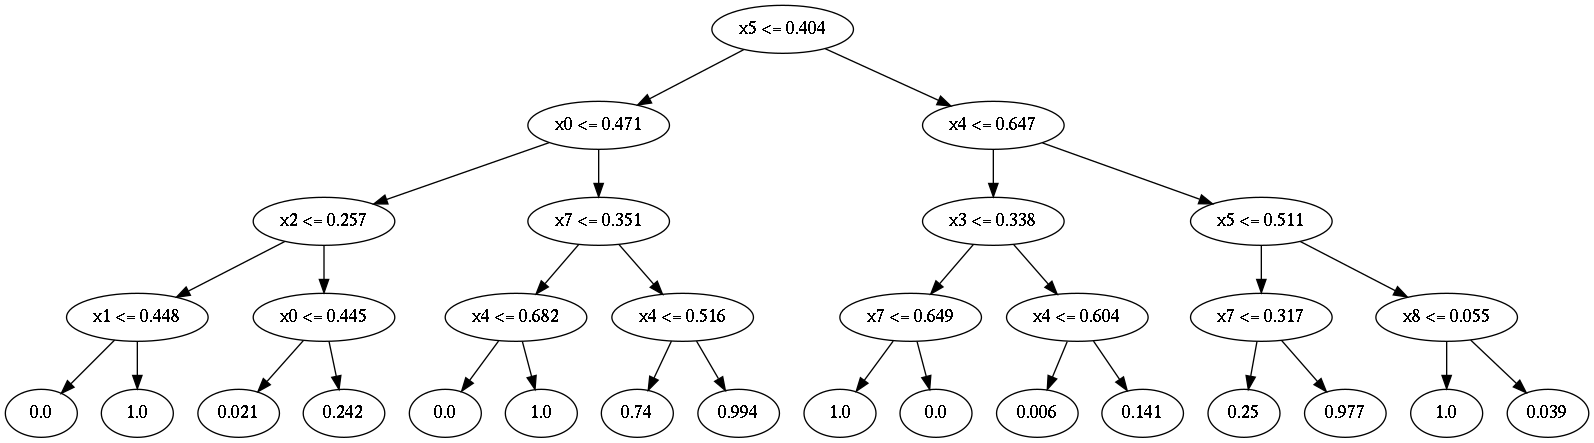

In [14]:
plot_tree_from_parameters(y_data_list[0][0].values, config)

In [15]:
path_functions = './data/saved_function_lists/functions_' + path_identifier_function_data + '.csv'
function_df.to_csv(path_functions, index=False)

path_X_data = './data/saved_function_lists/X_data_' + path_identifier_function_data + '.pkl'
with open(path_X_data, 'wb') as f:
    pickle.dump(X_data_list, f)
    
path_y_data = './data/saved_function_lists/y_data_' + path_identifier_function_data + '.pkl'
with open(path_y_data, 'wb') as f:
    pickle.dump(y_data_list, f)
